In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor, Pool

In [2]:
train=pd.read_csv('../data/final_train_no_outliers_with_geo.csv')
test=pd.read_csv('../data/test_with_geo.csv')

In [6]:
dino_cols = [f"dino_{i}" for i in range(768)]
sat_cols= [f"sat_feat_{i}" for i in range(256)]
target = 'price' # Ensure this matches your target column name
tab_cols = [c for c in train.columns if c not in dino_cols + [target]+sat_cols]

In [7]:
# Helper to group embedding features into a single column of lists
def prepare_embeddings(df):
    # This creates one column 'img_embedding' where each cell is a list of 768 floats
    df['img_embedding'] = df[dino_cols].values.tolist()
    # Drop individual columns and keep tabular data + 'img_embedding'
    # Update 'price' and 'image_name' to match your actual column names
    cols_to_drop = dino_cols 
    return df.drop(columns=cols_to_drop)

In [8]:
train_prepared = prepare_embeddings(train)
test_prepared = prepare_embeddings(test)

In [9]:
X = train_prepared.drop(columns=['price'])
y = train_prepared['price']

In [10]:
y_log = np.log1p(y)

In [11]:
embedding_indices = [X.columns.get_loc('img_embedding')]

In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
train_r2_scores = []
val_r2_scores = []

In [13]:
# CatBoost Parameters
params = {
    'iterations': 2000,
    'learning_rate': 0.07,
    'depth': 5,
    'eval_metric': 'R2',        # CatBoost supports R2 natively
    'early_stopping_rounds': 50,
    'verbose': 200,
    'l2_leaf_reg': 3,
    'random_strength': 42,
    'random_seed': 42,
}

In [14]:
print("Starting CatBoost 5-Fold CV using Native Embedding Support...\n")

# 3. Iterative Training Loop
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    # X_train_f, X_val_f = X.iloc[train_idx], X.iloc[val_idx]
    # y_train_f, y_val_f = y.iloc[train_idx], y.iloc[val_idx]
    X_train_f, X_val_f = X.iloc[train_idx], X.iloc[val_idx]
    y_train_log_f, y_val_log_f = y_log.iloc[train_idx], y_log.iloc[val_idx]
    y_train_orig_f, y_val_orig_f = y.iloc[train_idx], y.iloc[val_idx]
    # Create Pools (Essential for CatBoost to recognize embedding types)
    # train_pool = Pool(X_train_f, y_train_f, embedding_features=embedding_indices)
    # val_pool = Pool(X_val_f, y_val_f, embedding_features=embedding_indices)
    train_pool = Pool(X_train_f, y_train_log_f, embedding_features=embedding_indices)
    val_pool = Pool(X_val_f, y_val_log_f, embedding_features=embedding_indices)
    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=val_pool)
    
    # # Calculate R^2 for both train and validation
    # tr_preds = model.predict(train_pool)
    # vl_preds = model.predict(val_pool)
    
    # tr_r2 = r2_score(y_train_f, tr_preds)
    # vl_r2 = r2_score(y_val_f, vl_preds)
    
    # train_r2_scores.append(tr_r2)
    # val_r2_scores.append(vl_r2)
    
    # print(f"Fold {fold}: Train R^2 = {tr_r2:.4f} | Val R^2 = {vl_r2:.4f}")
    # 2. Predict (output will be on log scale)
    tr_log_preds = model.predict(train_pool)
    vl_log_preds = model.predict(val_pool)
    
    # 3. Invert predictions back to original scale
    tr_preds = np.expm1(tr_log_preds)
    vl_preds = np.expm1(vl_log_preds)
    # 4. Calculate R^2 on the ORIGINAL PRICE scale
    tr_r2 = r2_score(y_train_orig_f, tr_preds)
    vl_r2 = r2_score(y_val_orig_f, vl_preds)
    
    train_r2_scores.append(tr_r2)
    val_r2_scores.append(vl_r2)
    
    print(f"Fold {fold}: Train R^2 = {tr_r2:.4f} | Val R^2 = {vl_r2:.4f}")


Starting CatBoost 5-Fold CV using Native Embedding Support...

0:	learn: 0.0467385	test: 0.0454278	best: 0.0454278 (0)	total: 62.3ms	remaining: 2m 4s
200:	learn: 0.8838084	test: 0.8789543	best: 0.8789543 (200)	total: 378ms	remaining: 3.38s
400:	learn: 0.9169996	test: 0.9037521	best: 0.9037521 (400)	total: 696ms	remaining: 2.77s
600:	learn: 0.9285024	test: 0.9075807	best: 0.9075807 (600)	total: 1.02s	remaining: 2.38s
800:	learn: 0.9360981	test: 0.9089625	best: 0.9089679 (787)	total: 1.34s	remaining: 2s
1000:	learn: 0.9416182	test: 0.9099339	best: 0.9099807 (989)	total: 1.68s	remaining: 1.68s
1200:	learn: 0.9462738	test: 0.9104489	best: 0.9104518 (1181)	total: 1.98s	remaining: 1.32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9104942729
bestIteration = 1210

Shrink model to first 1211 iterations.
Fold 1: Train R^2 = 0.9558 | Val R^2 = 0.9134
0:	learn: 0.0470184	test: 0.0456982	best: 0.0456982 (0)	total: 2.87ms	remaining: 5.75s
200:	learn: 0.8857794	test: 0.8808283

In [16]:

# 4. Final Aggregated Results
print("\n" + "="*40)
print(f"AVERAGE TRAIN R^2:      {np.mean(train_r2_scores):.4f}")
print(f"AVERAGE VALIDATION R^2: {np.mean(val_r2_scores):.4f}")
print("="*40)


AVERAGE TRAIN R^2:      0.9533
AVERAGE VALIDATION R^2: 0.9144


In [17]:
# train the model on the entire training data and make predictions on the test set
final_train_pool = Pool(X, y_log, embedding_features=embedding_indices)
final_model = CatBoostRegressor(**params)
final_model.fit(final_train_pool)

0:	learn: 0.0666561	total: 5.29ms	remaining: 10.6s
200:	learn: 0.8851286	total: 1.59s	remaining: 14.3s
400:	learn: 0.9150048	total: 2.31s	remaining: 9.21s
600:	learn: 0.9255493	total: 4.29s	remaining: 9.99s
800:	learn: 0.9324445	total: 5.15s	remaining: 7.7s
1000:	learn: 0.9379250	total: 6.84s	remaining: 6.83s
1200:	learn: 0.9420380	total: 8.21s	remaining: 5.46s
1400:	learn: 0.9455212	total: 10.2s	remaining: 4.34s
1600:	learn: 0.9487218	total: 13.1s	remaining: 3.27s
1800:	learn: 0.9515821	total: 16.3s	remaining: 1.8s
1999:	learn: 0.9540777	total: 19s	remaining: 0us


In [18]:
train_prepared.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month', 'time_since_built',
       'time_since_renovated', 'month_sin', 'month_cos', 'lat_plus_lon',
       'lat_minus_lon', 'geo_cluster', 'img_embedding'],
      dtype='object')

In [19]:
# now make predictions on the test set
test_for_prediction=test_prepared[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month', 'time_since_built',
       'time_since_renovated', 'month_sin', 'month_cos', 'lat_plus_lon',
       'lat_minus_lon', 'geo_cluster', 'img_embedding']]


In [20]:
predictions_price_for_test=final_model.predict(test_for_prediction)

In [21]:
# add this as a new column to test_prepared
test_prepared['predicted_price'] = np.expm1(predictions_price_for_test)

In [22]:
final_test=test_prepared[['id', 'predicted_price']]

In [23]:
final_test

,id,predicted_price
0,2591820310,3.680782e+05
1,7974200820,8.503763e+05
2,7701450110,1.262463e+06
3,9522300010,1.772991e+06
4,9510861140,7.079449e+05
...,...,...
5399,7732500270,6.910085e+05
5400,3856903515,6.471006e+05
5401,2557000400,2.726851e+05
5402,4386700135,1.948148e+06


In [24]:
final_test.to_csv('../submission/catboost_dino_test_predictions_2.csv',index=False)

In [25]:
final_model.save_model('../models/catboost_dino_model_v2.cbm')

# Analysis

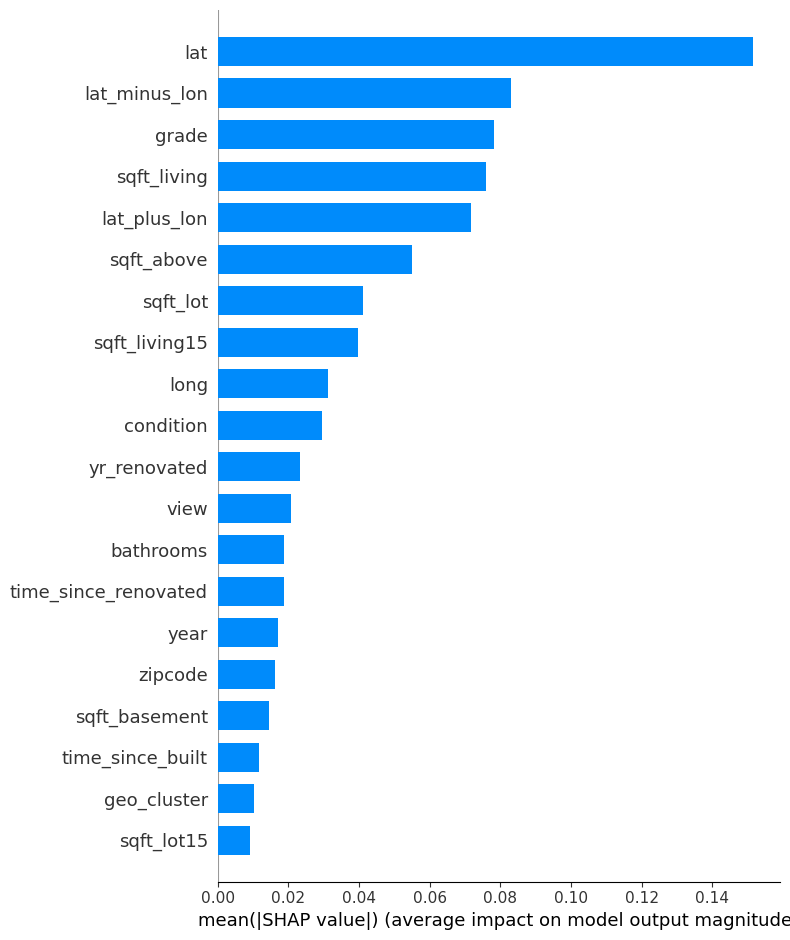

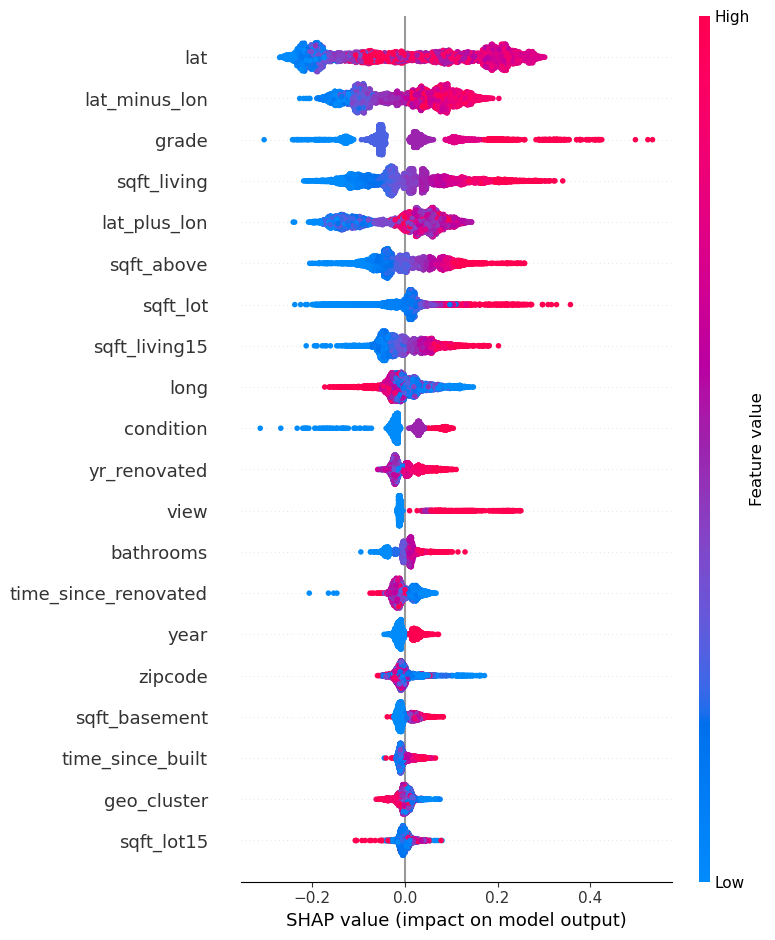


--- Waterfall Plot for Example 0 ---


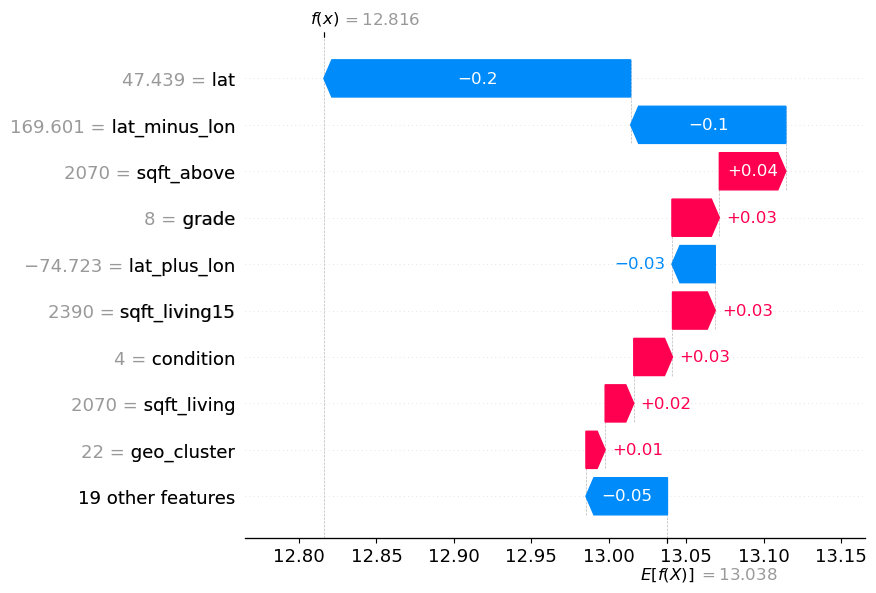


--- Waterfall Plot for Example 1 ---


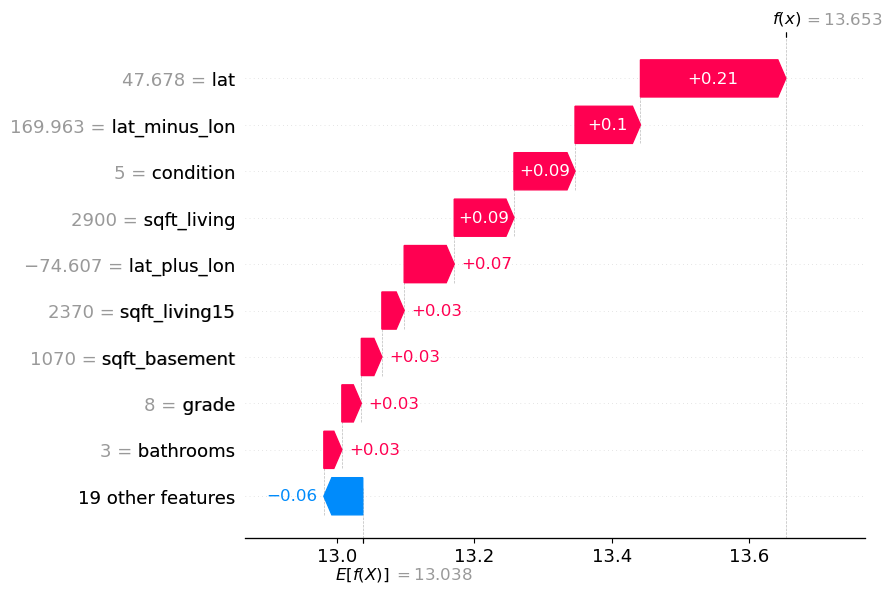


--- Waterfall Plot for Example 2 ---


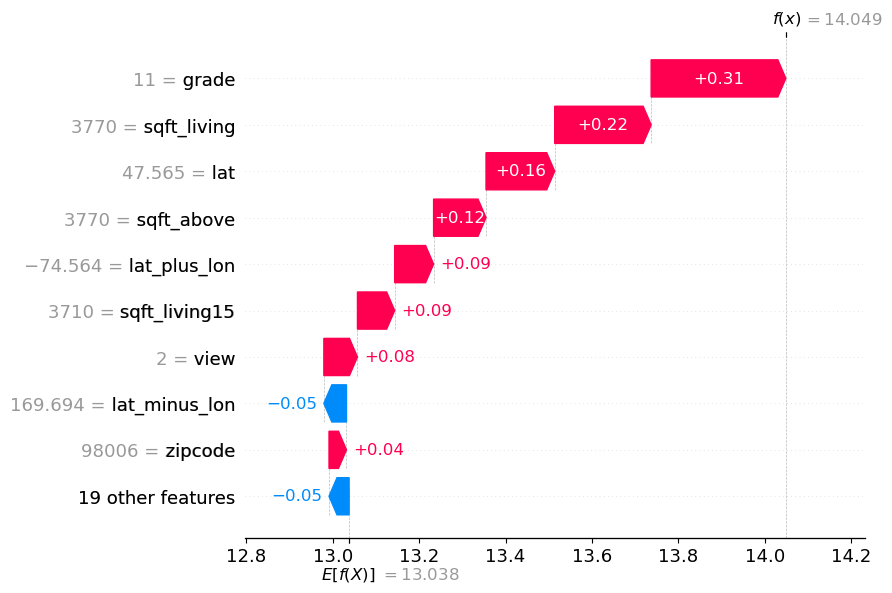

In [26]:
import shap

# Create SHAP explainer for CatBoost model
explainer = shap.TreeExplainer(final_model)

# Prepare test data for SHAP (need to handle embedding features)
# Create a Pool for SHAP analysis
test_pool_for_shap = Pool(test_for_prediction, embedding_features=embedding_indices)

# Calculate SHAP values
shap_values = explainer.shap_values(test_pool_for_shap)

# Feature importance bar plot
shap.summary_plot(shap_values, test_for_prediction, plot_type="bar", show=True)

# Beeswarm plot
shap.summary_plot(shap_values, test_for_prediction, show=True)

# Waterfall plots for 3 examples
for i in range(3):
    print(f"\n--- Waterfall Plot for Example {i} ---")
    shap.waterfall_plot(shap.Explanation(values=shap_values[i], 
                                          base_values=explainer.expected_value, 
                                          data=test_for_prediction.iloc[i],
                                          feature_names=test_for_prediction.columns.tolist()))